# 0. Opdracht Beschrijving

## 0.1. Probleemstelling

Bij onderzoeken naar gewelddadige misdrijven zoals overvallen en schietincidenten is het voor de FBI vaak lastig om snel en betrouwbaar vast te stellen welk type vuurwapen is gebruikt. In veel gevallen is direct fysiek bewijs beperkt of nog niet beschikbaar, terwijl er wel andere vormen van informatie aanwezig zijn, zoals geluidsopnames van schoten, afbeeldingen van wapens of tekstuele beschrijvingen in rapporten en getuigenverklaringen. Het ontbreken van een duidelijke vaststelling van het wapentype kan het opsporingsproces vertragen en de onderbouwing van bewijs in de rechtbank verzwakken. Het doel van ons project is het ontwikkelen van een data engineering pipeline die audio, afbeeldingen en tekst data samenbrengt om het type vuurwapen te voorspellen. Het "model" richt zich op het classificeren van wapens in categorieen zoals pistool, revolver, geweer, shotgun en automatisch wapen. Door kenmerken zoals schiet tempo, kaliber, actie-type en fysieke eigenschappen van het wapen te combineren, kan het systeem de FBI ondersteunen bij het inschatten van het type misdrijf en de ernst ervan. Hiermee wordt het analyseproces versneld en wordt aanvullende objectieve ondersteuning geleverd voor strafzaken.

## 0.2. Zakelijke Inzicht En Literatuur Onderzoek

Vanuit zakelijk perspectief is dit project gericht op het ondersteunen van FBI-rechercheurs bij het herkennen van het type vuurwapen dat is gebruikt bij een misdrijf. Deze informatie kan helpen om een zaak beter te begrijpen en sneller beslissingen te nemen tijdens een onderzoek. Het systeem is bedoeld als een extra informatiebron die wordt gecombineerd met ander bewijsmateriaal.

Het onderzoek binnen dit project richt zich op het vinden en gebruiken van geschikte databronnen voor het automatisch herkennen van vuurwapentypen. Voor audio is een publieke Kaggledataset met vuurwapengeluiden gebruikt, waarmee kenmerken zoals het gemiddeld aantal schoten per tijdseenheid kunnen worden bepaald. Tekstuele informatie is verzameld via webscraping van Guns Fandom, waar beschrijvingen van wapens beschikbaar zijn. Afbeeldingen van vuurwapens zijn opgehaald via de Wikimedia Commons API. De data uit deze bronnen bestaan uit ongestructureerde en semi-gestructureerde formaten en worden verwerkt tot een gestructureerde dataset die geschikt is voor verdere analyse en classificatie.

# 1. Imports En Data Extraction

## 1.1 Packages

In [3]:
import pandas as pd
import numpy as np
import requests
from selenium import webdriver
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
import librosa
import random
import time
import requests
from urllib.parse import unquote

## 1.2 Audio Dataset Van kaggle.com

Voor de audioanalyse wordt een publieke Kaggle dataset met vuurwapengeluiden gebruikt. De dataset bevat 58 verschillende vuurwapens, waarbij per vuurwapen meerdere korte audiofragmenten beschikbaar zijn. Elk audiofragment heeft een vaste lengte van 0,5 seconde en bevat een schot of korte schotreeks. Deze dataset is als eerste gekozen, omdat geschikte audiodata het moeilijkst te vinden was voor dit project. De audio vormt daarom de basis van de verdere dataverzameling. De audiobestanden zijn gestructureerd in mappen met de naam van het vuurwapen, waardoor deze mapnamen gebruikt kunnen worden als metadata. Op basis hiervan is een dataframe opgebouwd waarin het vuurwapenmodel en het bijbehorende audio zijn vastgelegd.

In [6]:
audio_path = "data/audio/original_dataset/"
audio_files = os.listdir(audio_path)
audio_df = pd.DataFrame({
    'model': [os.path.splitext(f)[0] for f in audio_files],
    'path': [os.path.join(audio_path, f) for f in audio_files]
})
print(audio_df.head(50))

                          model  \
0           38sws-dot38-caliber   
1                         ak-12   
2                         ak-47   
3         arctic-warfare-magnum   
4                    beretta-92   
5                     colt-1911   
6                     daewoo-k2   
7                  desert-eagle   
8         double-barrel-shotgun   
9                     dp-27-lmg   
10                       fn-p90   
11                      fn-scar   
12                        glock   
13                    glock-18c   
14    glock-19-9mm-luger-pistol   
15           high-standard-22lr   
16                      hk-g36c   
17                     hk-ump45   
18  hk-usp-compact-40-sw-pistol   
19                       kar98k   
20                 kimber-45acp   
21                 kriss-vector   
22                lorcin-380acp   
23                          m16   
24                      m24-sws   
25                     m249-lmg   
26                           m4   
27                  

## 1.3 Image API Van wikimedia.org

Voor de beeldanalyse wordt gebruikgemaakt van afbeeldingen die via de Wikimedia Commons API zijn opgehaald. Wikimedia is gekozen omdat het een grote, publieke en vrij toegankelijke verzameling bevat van vuurwapenafbeeldingen, gestructureerd per categorie en voorzien van metadata. De afbeeldingen worden opgehaald op basis van modelnamen van vuurwapens, die eerder zijn verkregen uit de audiodataset. Hierdoor kan dezelfde firearm naam worden gebruikt over meerdere databronnen heen. De Wikimedia API levert semi-gestructureerde data in JSON-formaat. Eerst wordt via een zoekquery gezocht naar relevante afbeelding titels binnen de bestanden. Vervolgens worden per titel de directe image URL’s opgevraagd en lokaal opgeslagen. Alleen bestanden met een geldig image content type worden geaccepteerd, zodat niet relevante resultaten zoals documenten of HTML-pagina’s worden gefilterd. De opgehaalde afbeeldingen worden opgeslagen als JPG-bestanden, met daarnaast een csv-bestand waarin per afbeelding het vuurwapenmodel, de bron URL en het lokale bestandspad zijn vastgelegd. Deze metadata maakt het mogelijk om de afbeeldingen later te koppelen aan andere modaliteiten in het project. De beelden worden in een volgende stap gebruikt voor eenvoudige image analyse, zoals het bepalen van grip_style (eenhandig of tweehandig) en barrel_length (kort of lang). Op deze manier vormt de Wikimedia API een betrouwbare en schaalbare bron voor visuele informatie binnen de multimodale dataset.

In [7]:
from image_api import ImageAPI
API_URL = "https://commons.wikimedia.org/w/api.php"
HEADERS = {"User-Agent": "Pipline/1.0 (mkakol.index@gmail.com)"}
audio_files = os.listdir(audio_path)
models = [os.path.splitext(f)[0] for f in audio_files]
image_df = ImageAPI(API_URL, HEADERS).fetch_images_for_models(models)

Searching for 38sws-dot38-caliber...
No image found for 38sws-dot38-caliber.
Searching for ak-12...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/c/c2/5%2C45mm_AK-12_6P70_assault_rifle_at_Military-technical_forum_ARMY-2016_03_noBG.png
Searching for ak-47...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/f/f6/AK-47_assault_rifle.jpg
Searching for arctic-warfare-magnum...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/0/0f/AWM-338-white.jpg
Searching for beretta-92...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/2/24/Beretta_92S_%28cropped%29.jpg
Searching for colt-1911...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/c/cf/Colt_M1911_Pistol_from_1912_Army_manual.png
Searching for daewoo-k2...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/5/59/Daewoo_K2_rifle_1.jpg
Searching for desert-eagle...
Downloaded: https://upload.wikimedia.org/wikipedia/commons/8/81/2014-_Desert_Eagle_.50_Action_Express_Semi-Automatic_Pis

## 1.4 Web Scraping Text Van gunsfandom.com

Voor het bepalen van het wapen type wordt tekstuele informatie verzameld van GunsFandom.com. Deze website is gekozen omdat per vuurwapen een beschrijvende introductietekst beschikbaar is waarin vaak expliciet wordt aangegeven om welk type wapen het gaat, zoals bijvoorbeeld assault rifle, pistol of shotgun. Deze beschrijving vormt de basis voor de targetvariabele weapon_type en is daarmee een belangrijk onderdeel van de classificatie.

Een eerdere aanpak, waarbij direct pagina-URL’s werden opgebouwd op basis van de vuurwapennaam of waarbij vaste pagina elementen werden aangesproken, bleek in de praktijk onvoldoende betrouwbaar. Dit kwam onder andere doordat GunsFandom gebruikmaakt van JavaScript gegenereerde content en doordat vuurwapennamen niet altijd exact overeenkomen met de daadwerkelijke paginanamen op de website. Hierdoor werden pagina’s regelmatig niet gevonden of werd onjuiste inhoud opgehaald. Om dit probleem te verhelpen wordt nu gebruikgemaakt van een zoekgebaseerde web scraping aanpak. Voor elk vuurwapenmodel wordt eerst de interne zoekfunctie van GunsFandom gebruikt om de juiste pagina te vinden. Vervolgens wordt de bijbehorende vuurwapenpagina opgehaald en wordt de eerste betekenisvolle paragraaf uit de hoofdtekst geextraheerd. Deze paragraaf bevat doorgaans een algemene beschrijving van het wapen en vormt daarmee een consistente bron van informatie.

De verkregen tekstdata is ongestructureerd en wordt in eerste instantie ongewijzigd opgeslagen, zodat de originele terminologie van de bron behouden blijft. In een latere fase van feature engineering wordt deze tekst omgezet naar gestandaardiseerde categorieen (zoals pistol, rifle en shotgun) die uiteindelijk worden gebruikt als target voor het "classificatiemodel".

In [4]:
from text_webscraping import get_fandom_text
url = "https://guns.fandom.com/wiki/AK-47"
paras = get_fandom_text(url)
for i, p in enumerate(paras[:10]):
    print(p)

<p class="sitenotice-wrapper__title">Gun Wiki</p>
<p><font face="Verdana">
</font></p>
<p><font face="Verdana"><b><span style="font-size:160%; color:#FF0000;">M.O.S.</span> —</b> <span style="font-size:120%; color:#000;">Please read and keep the <b><a href="/wiki/Gun_Wiki:Manual_of_Style" title="Gun Wiki:Manual of Style">Manual of Style</a></b> in mind while editing.</span>
</font></p>
<p><font face="Verdana"><b><span style="font-size:120%; color:#FF0000;">Also, remember that there is to be no copying and pasting from other sources, at any time - your edits must be in your OWN words!</span></b>
</font></p>
<p>READ MORE</p>
<p>
<aside class="portable-infobox pi-background pi-border-color pi-theme-wikia pi-layout-default" role="region">
<div class="pi-image-collection wds-tabber" data-source="image">
<div class="wds-tabs__wrapper">
<ul class="wds-tabs">
<li class="wds-tabs__tab wds-is-current">
<span class="wds-tabs__tab-label">
							AK-47
							
						</span>
</li>
<li class="wds-tab

In [3]:
from text_webscraping import get_fandom_texts
descriptions_df = get_fandom_texts(audio_df)
pd.set_option("display.max_colwidth", None)
print(descriptions_df)

                          model  \
0           38sws-dot38-caliber   
1                         ak-12   
2                         ak-47   
3         arctic-warfare-magnum   
4                    beretta-92   
5                     colt-1911   
6                     daewoo-k2   
7                  desert-eagle   
8         double-barrel-shotgun   
9                     dp-27-lmg   
10                       fn-p90   
11                      fn-scar   
12                        glock   
13                    glock-18c   
14    glock-19-9mm-luger-pistol   
15           high-standard-22lr   
16                      hk-g36c   
17                     hk-ump45   
18  hk-usp-compact-40-sw-pistol   
19                       kar98k   
20                 kimber-45acp   
21                 kriss-vector   
22                lorcin-380acp   
23                          m16   
24                      m24-sws   
25                     m249-lmg   
26                           m4   
27                  

# 2. EDA

## 2.1 Audio EDA

We nemen de audio dataset als basis, omdat deze als enige direct gestructureerd is. Elke subfolder is genoemd naar een firearm, wat we gebruiken als identifier om data te koppelen aan afbeeldingen of tekst. Zo hoeven we de namen niet handmatig in te vullen en vormt het een natuurlijke basis voor de pipeline.

De dataset bevat 1450 bestanden, verdeeld over 58 unieke vuurwapens, dus 25 audio’s per wapen. Dit helpt om de variatie in geluid per wapen te bekijken. Het doel is het berekenen van avg_shots_per_sec en kijken naar correlatie met de target weapon_type (pistol, rifle, shotgun).

Elke sample is 0,5 seconde lang, met een sample rate van 22050 Hz. Het exact detecteren van schoten bleek lastig, daarom is een aangepaste functie gebruikt die RMS-energie van de audio berekent om de pieken stabieler te detecteren. Door parameters voor prominente pieken, minimumhoogte en minimale afstand tussen pieken aan te passen, kan de functie best wel betrouwbaar zien of er een of meerdere schoten in een fragment zijn, ook bij korte clips met echo of ruis.

Voor feature engineering trekken we metadata uit de audio: het aantal gedetecteerde pieken voor avg_shots_per_sec en de amplitude voor avg_loudness. Signalen bevatten veel ruis, maar meestal overheerst een duidelijke frequentie, waardoor een uitgebreide Fourier analyse niet nodig is. Gemeten minimum en piekfrequenties liggen tussen 2 en 3844 Hz, wat bruikbaar is voor het beoordelen van het volume en de schot activiteit.

Audio files: 1450
Unique firearms: 58
Audios per firearm: {'38sws-dot38-caliber': 25, 'ak-12': 25, 'ak-47': 25, 'arctic-warfare-magnum': 25, 'beretta-92': 25, 'colt-1911': 25, 'daewoo-k2': 25, 'desert-eagle': 25, 'double-barrel-shotgun': 25, 'dp-27-lmg': 25, 'fn-p90': 25, 'fn-scar': 25, 'glock': 25, 'glock-18c': 25, 'glock-19-9mm-luger-pistol': 25, 'high-standard-22lr': 25, 'hk-g36c': 25, 'hk-ump45': 25, 'hk-usp-compact-40-sw-pistol': 25, 'kar98k': 25, 'kimber-45acp': 25, 'kriss-vector': 25, 'lorcin-380acp': 25, 'm16': 25, 'm24-sws': 25, 'm249-lmg': 25, 'm4': 25, 'mg42-lmg': 25, 'mini-14': 25, 'mk14-ebr': 25, 'mp-40-40-sw-pistol': 25, 'mp5-smg': 25, 'nagant-m1895': 25, 'ots-14-groza': 25, 'pp-19-bizon': 25, 'pump-action-shotgun': 25, 'qbu-88': 25, 'qbz-95': 25, 'remington-22lr': 25, 'remington-700': 25, 'remington-870': 25, 'rhino-60ds': 25, 'ruger-22lr': 25, 'ruger-357': 25, 'ruger-ar-556': 25, 'saiga-12k': 25, 'sig-p225': 25, 'sks-rifle': 25, 'slr-rifle': 25, 'steyr-aug': 25, 'sw-10-

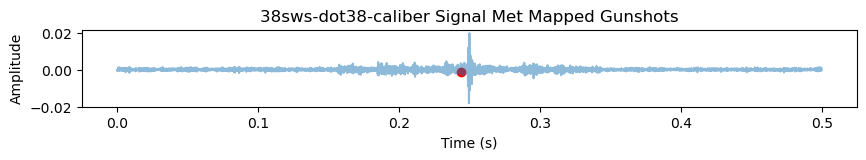

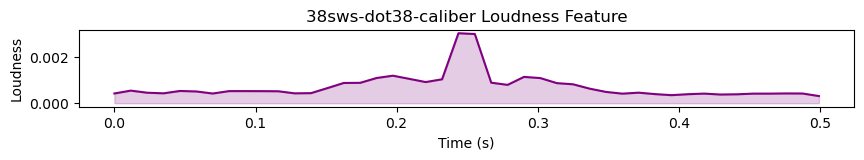

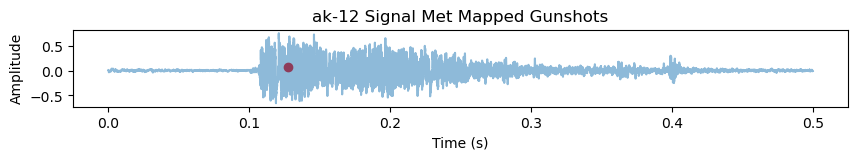

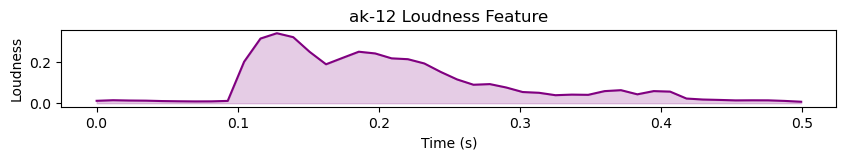

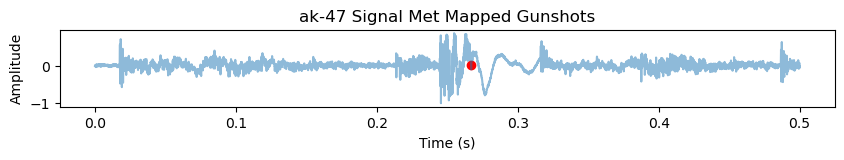

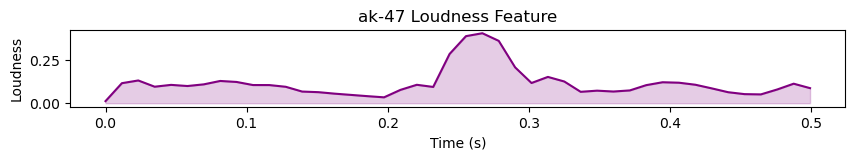

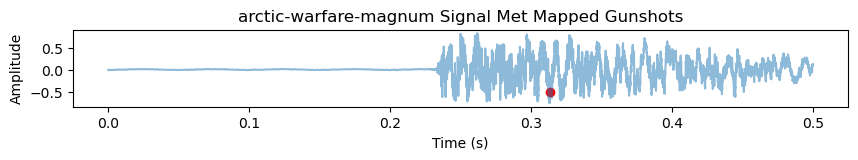

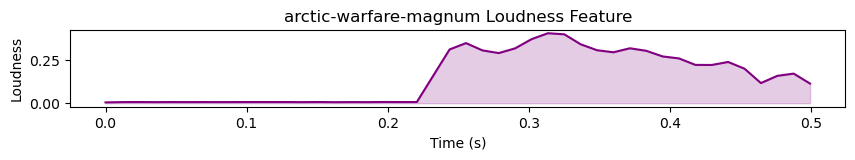

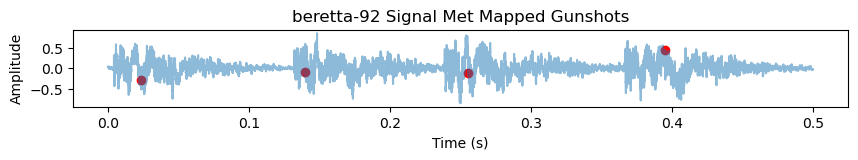

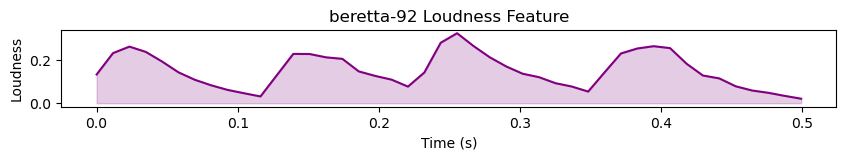

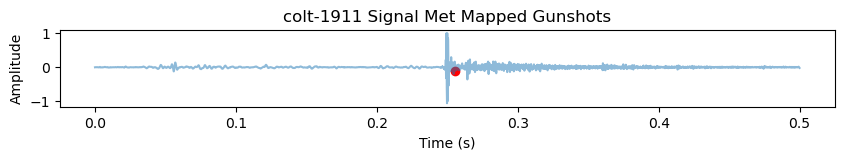

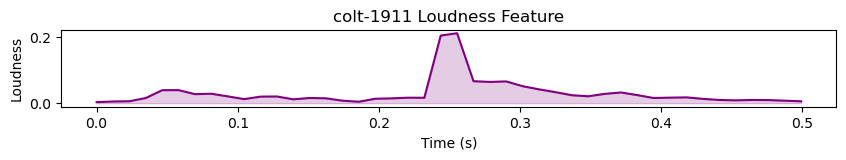

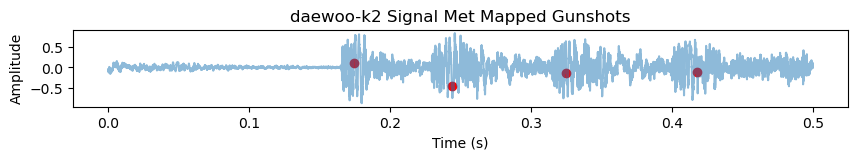

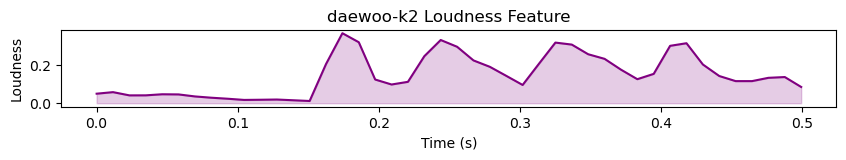

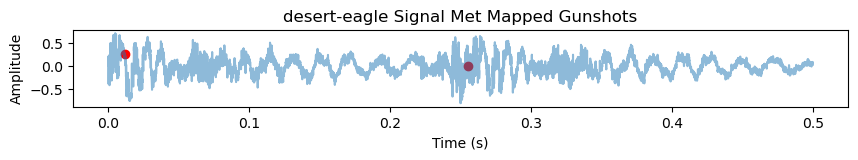

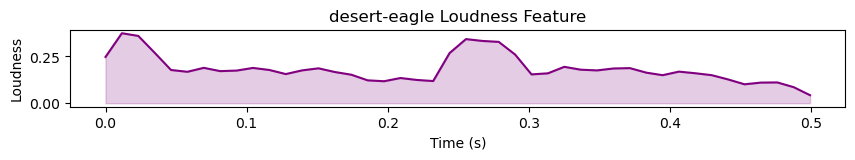

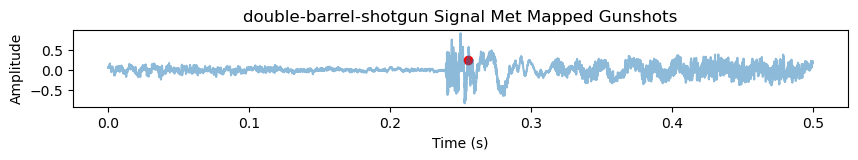

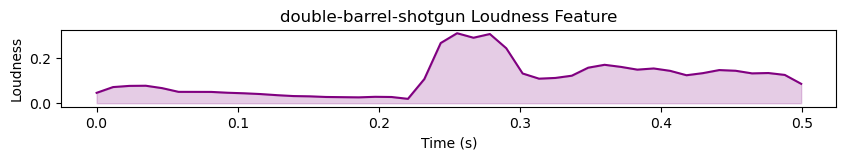

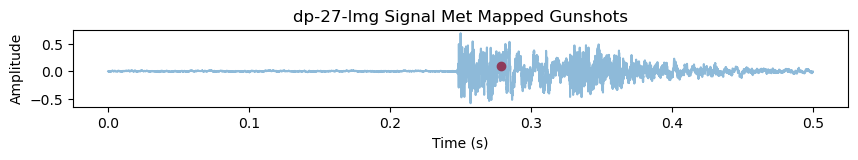

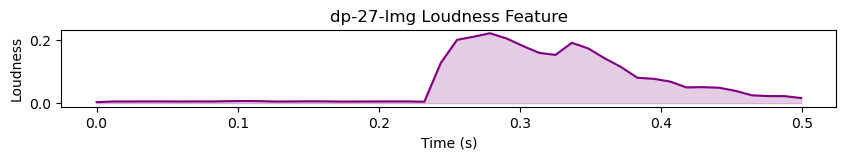

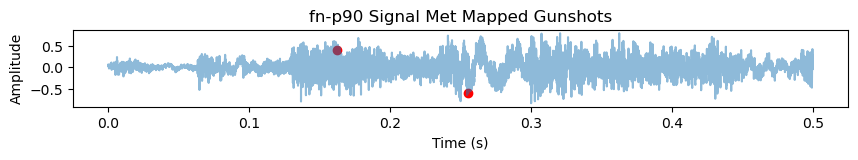

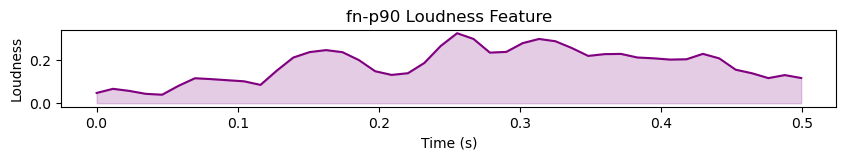

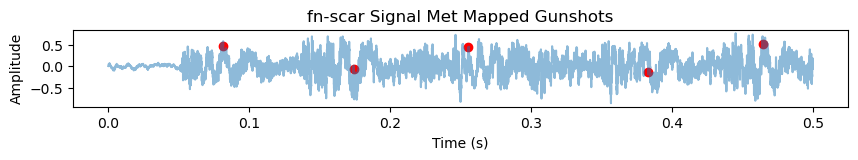

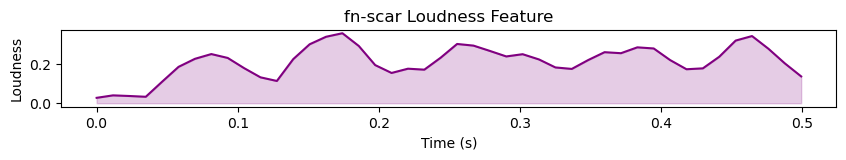

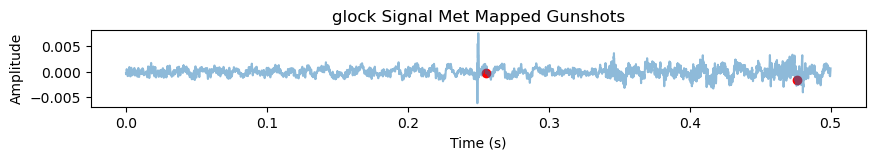

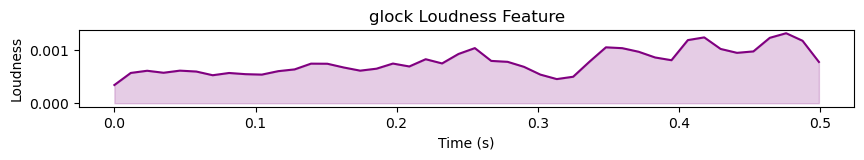

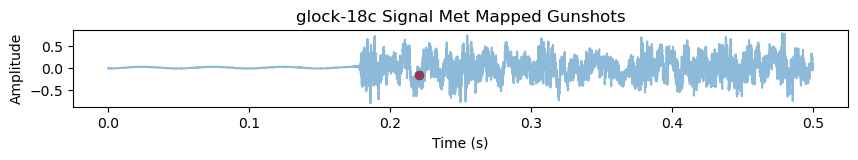

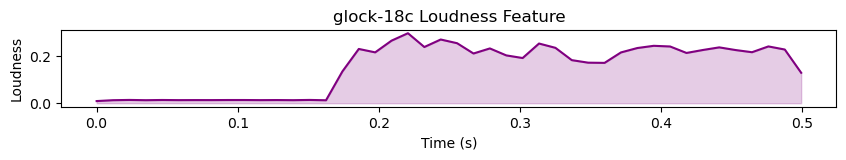

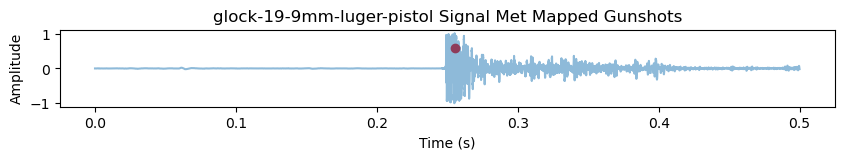

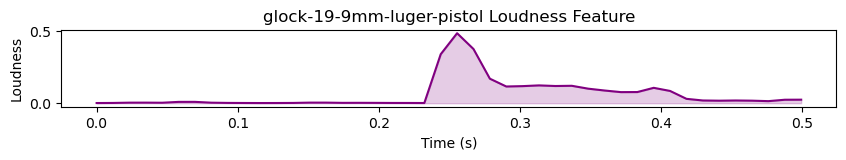

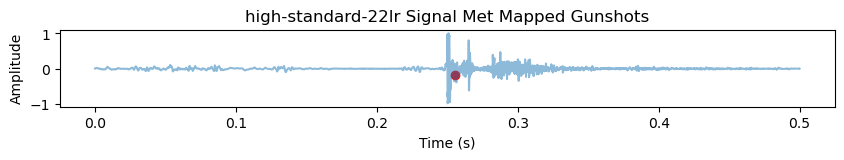

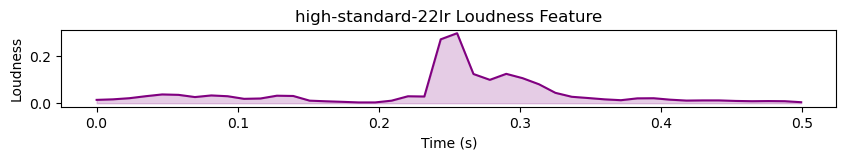

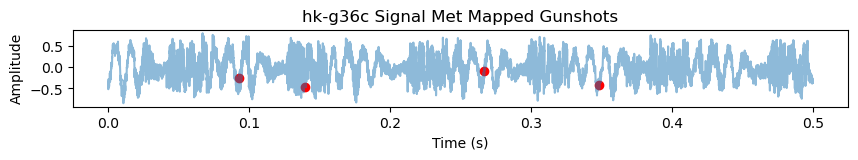

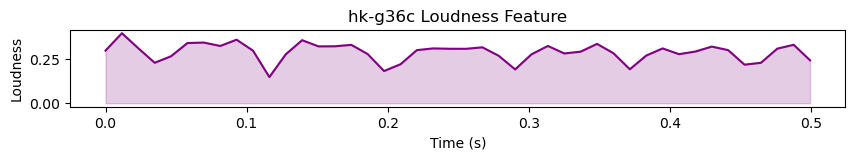

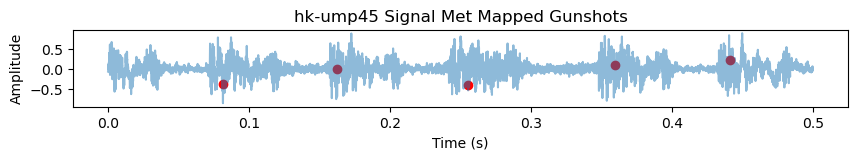

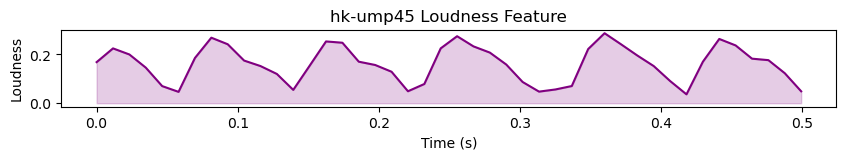

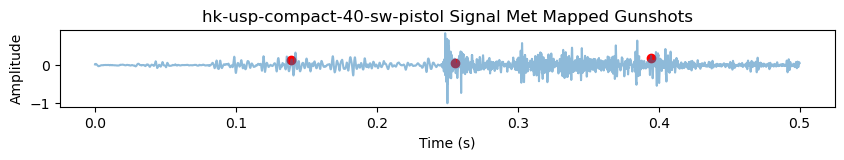

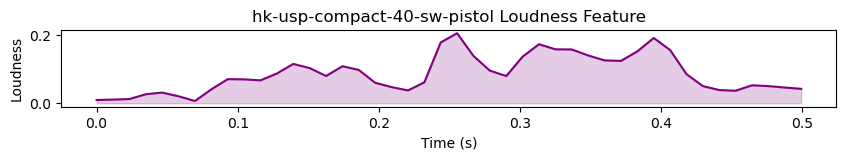

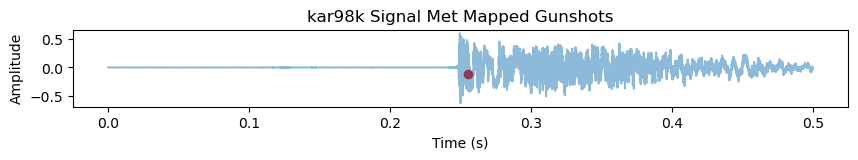

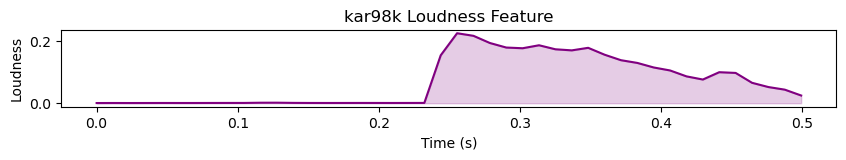

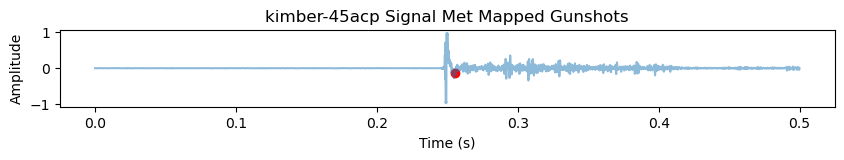

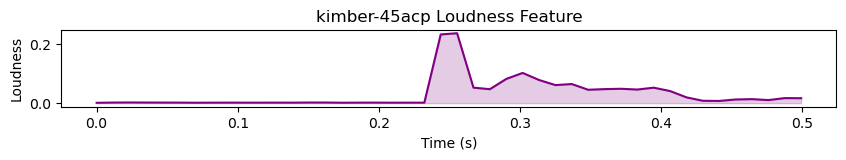

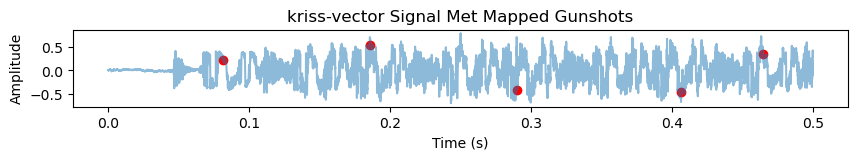

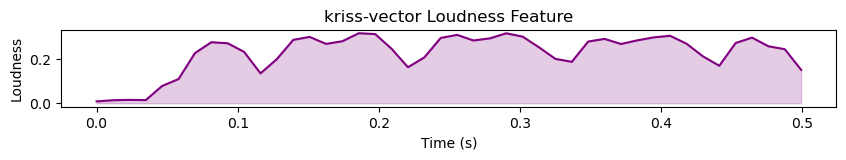

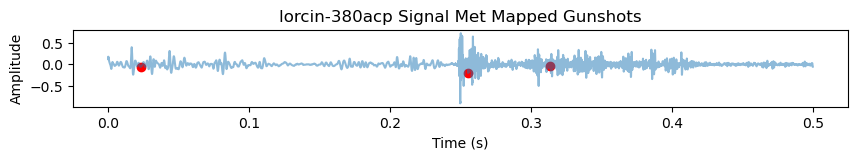

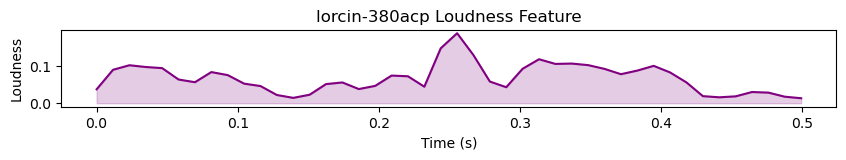

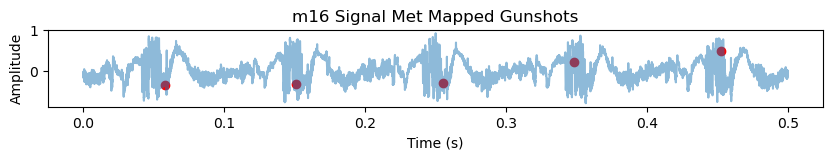

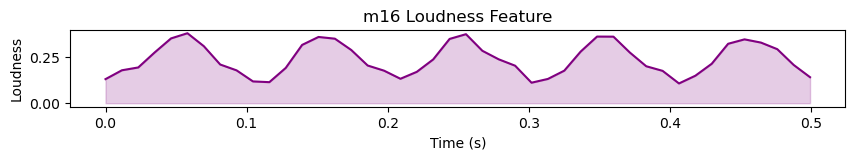

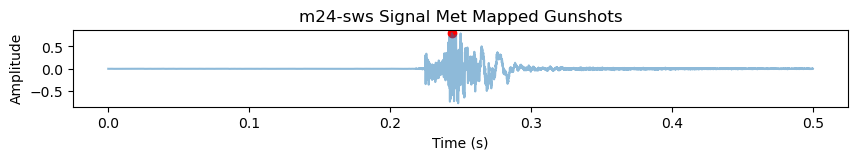

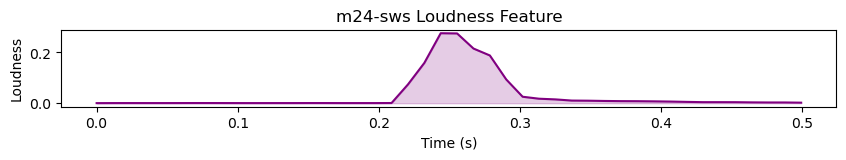

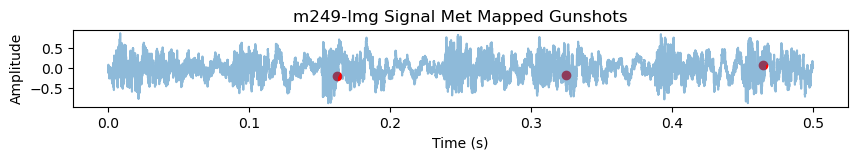

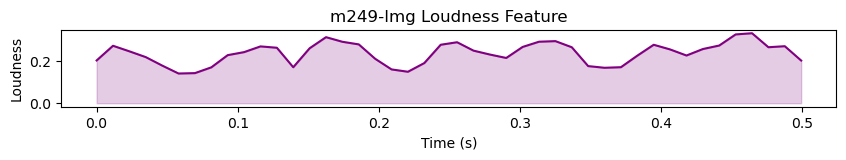

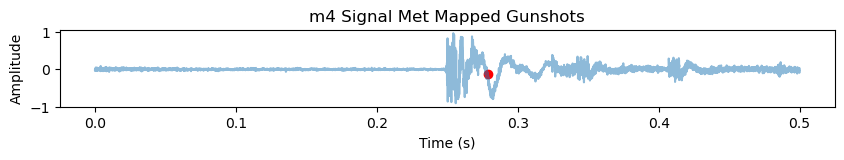

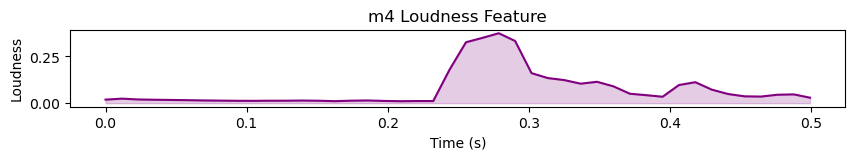

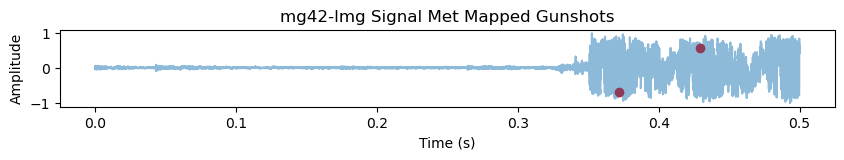

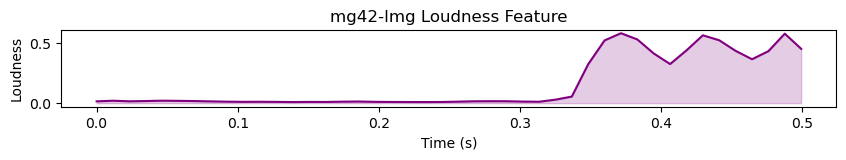

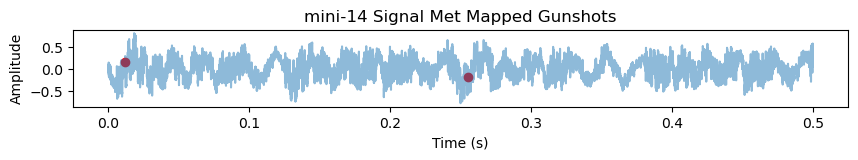

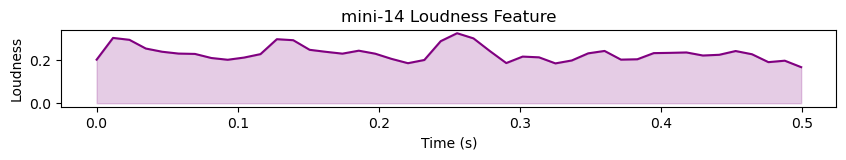

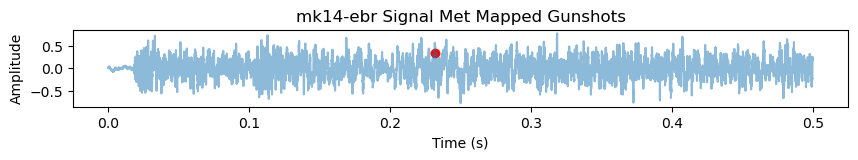

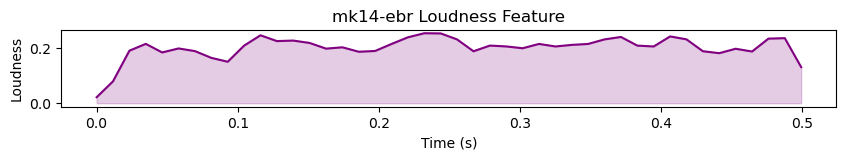

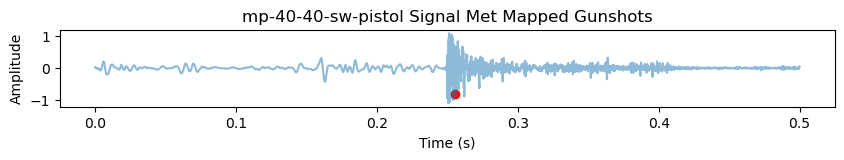

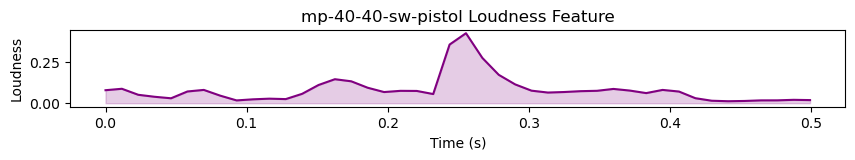

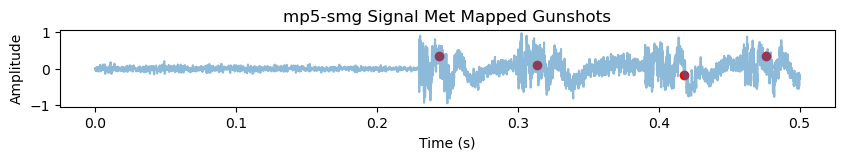

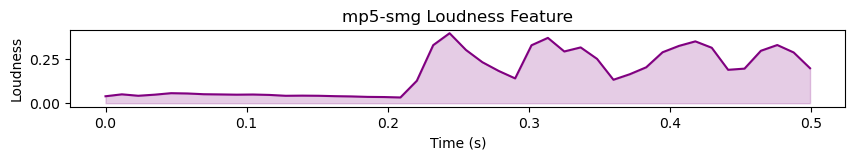

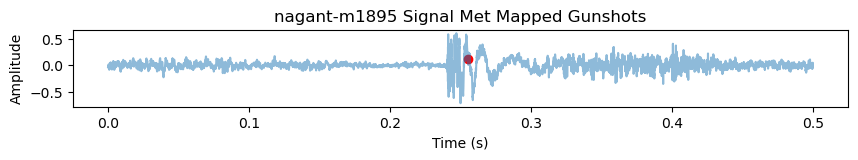

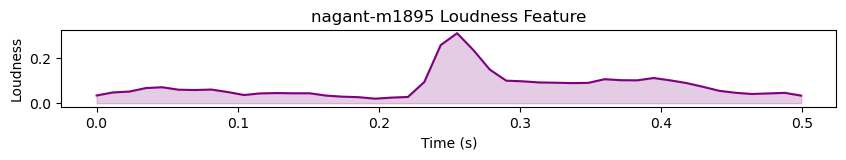

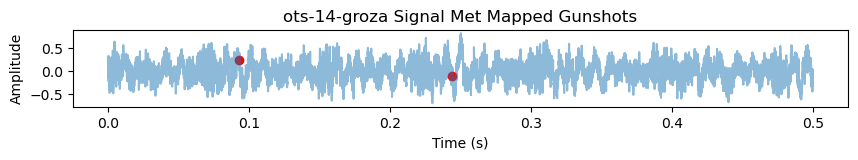

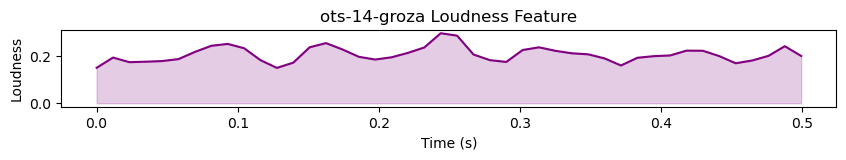

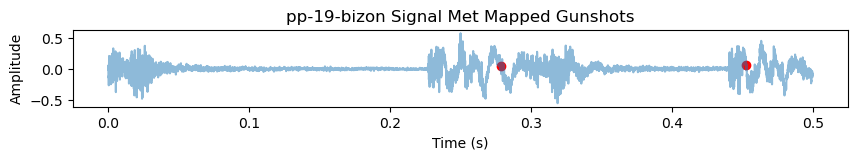

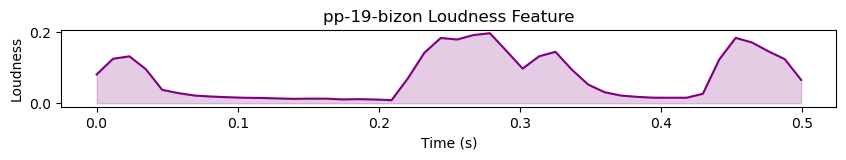

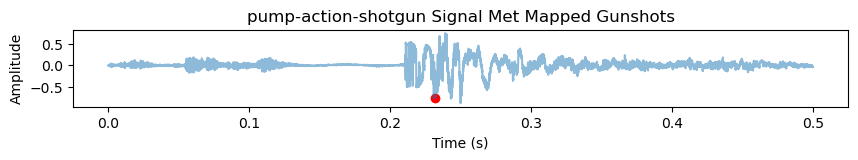

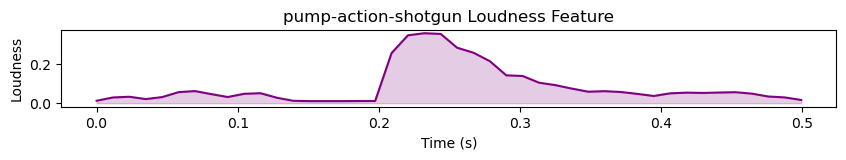

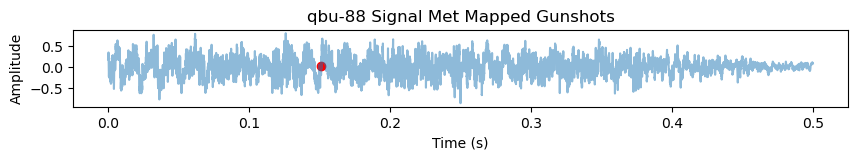

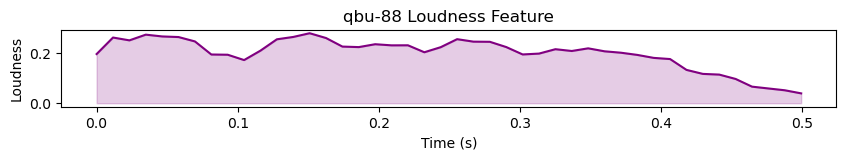

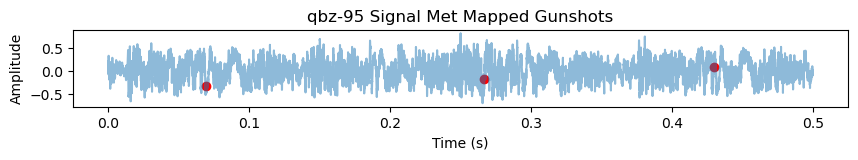

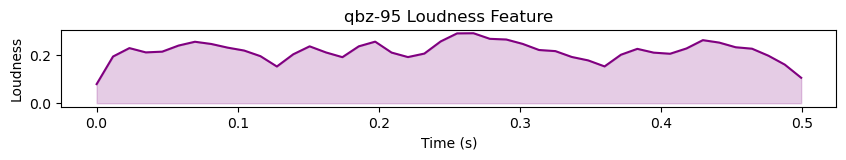

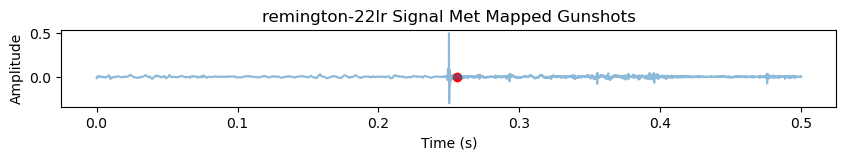

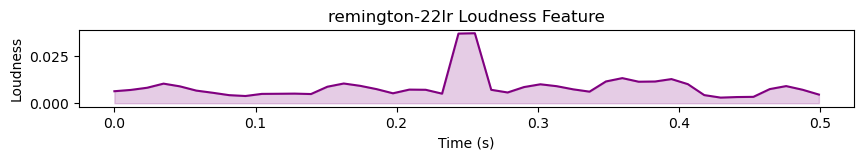

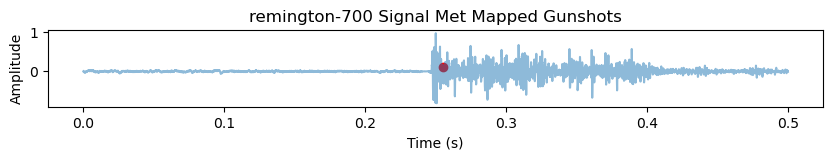

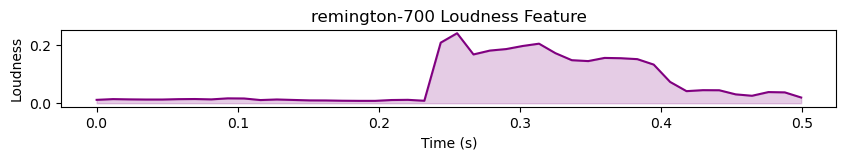

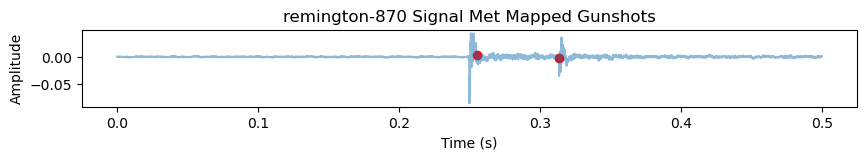

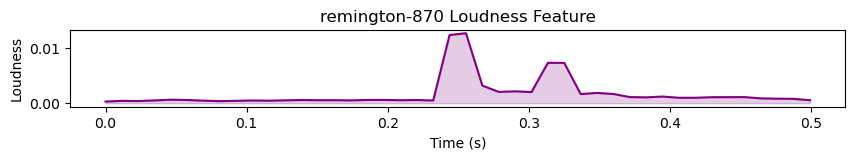

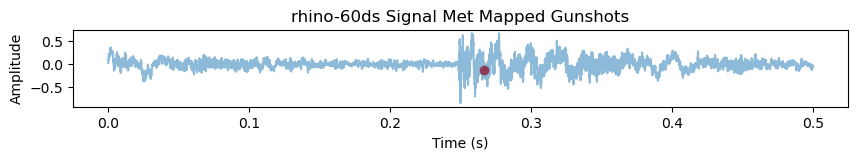

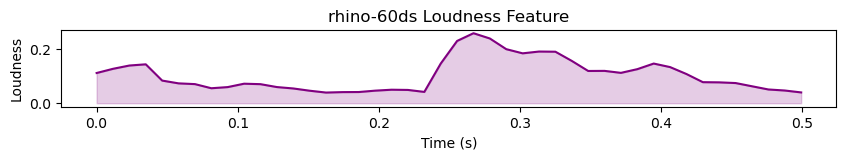

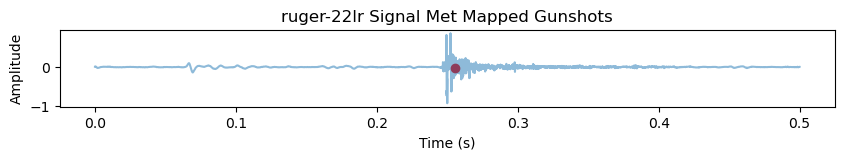

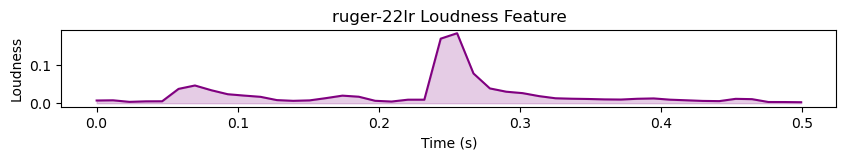

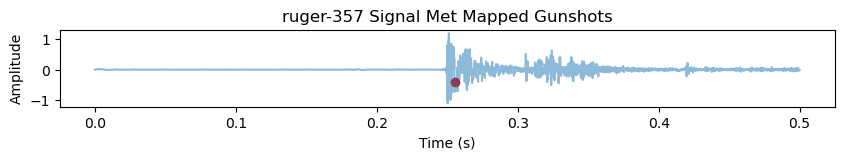

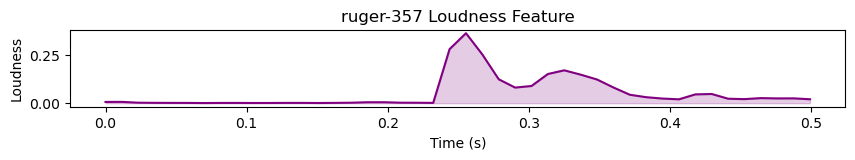

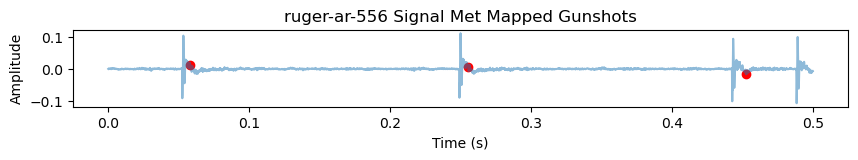

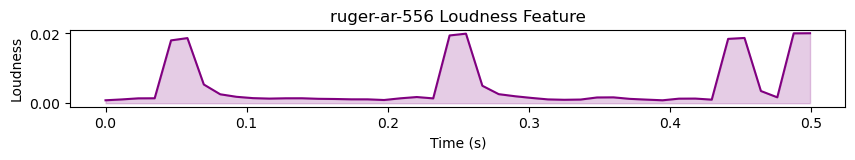

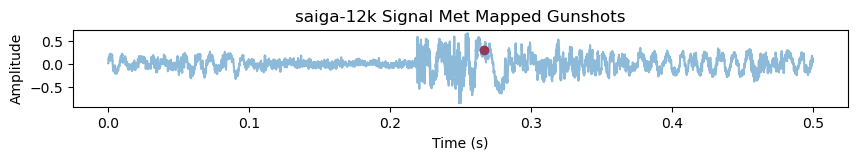

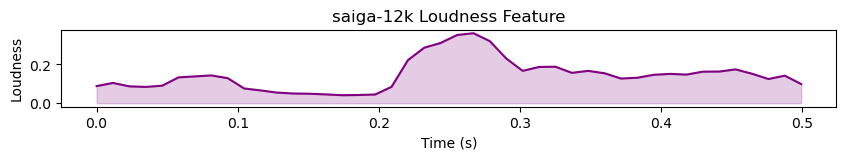

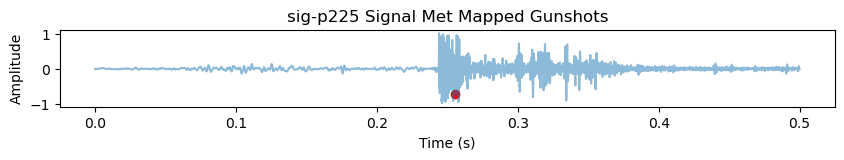

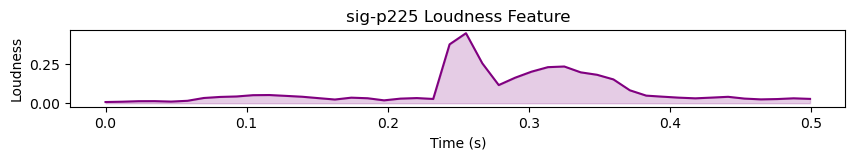

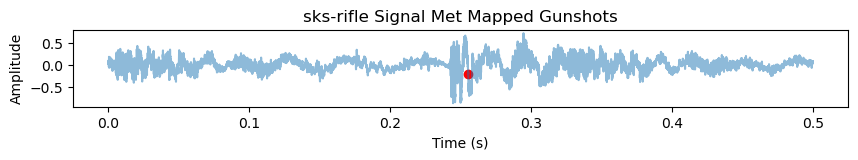

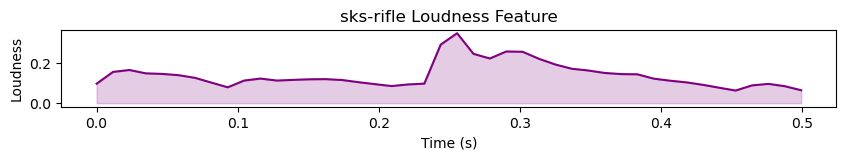

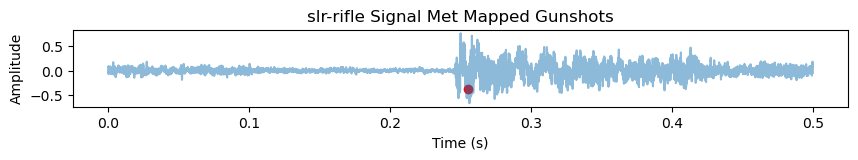

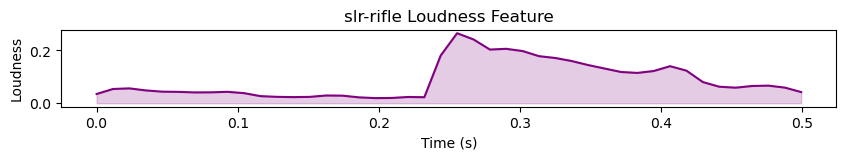

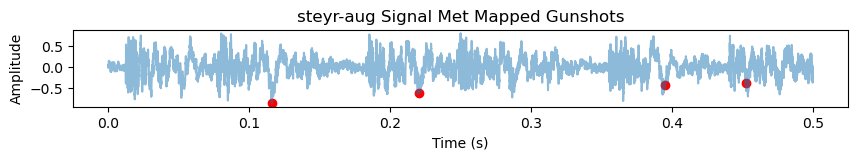

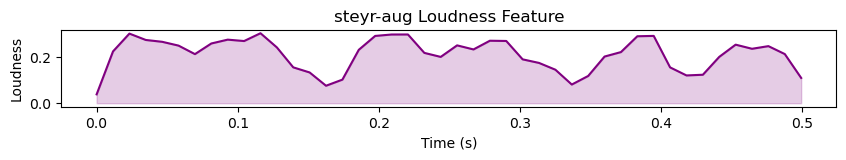

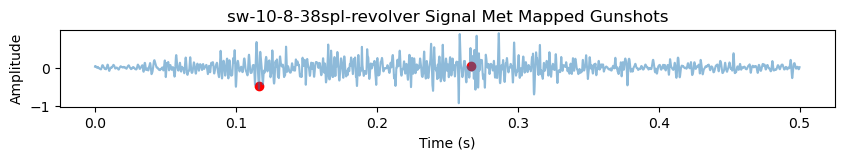

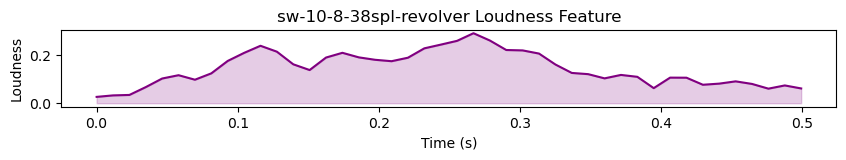

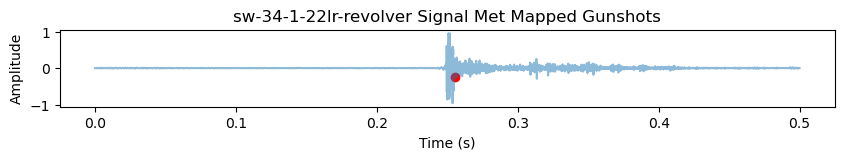

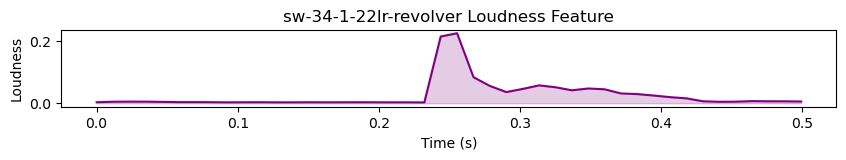

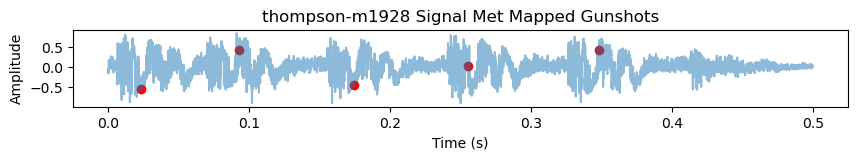

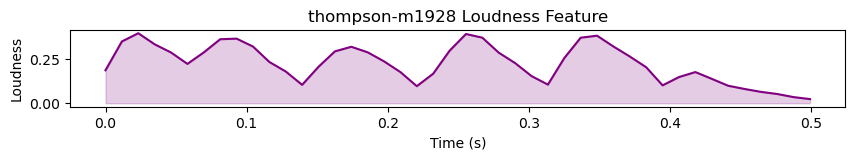

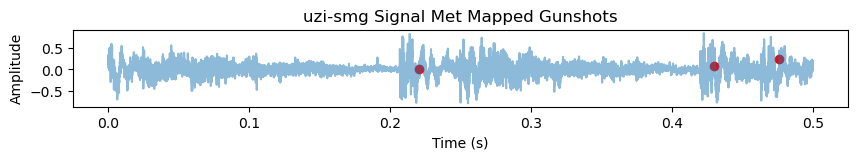

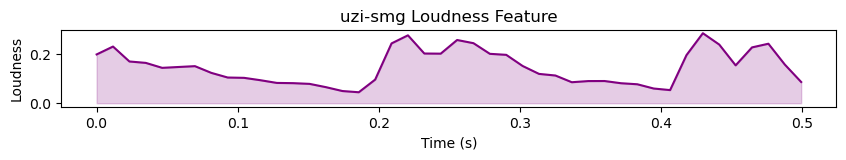

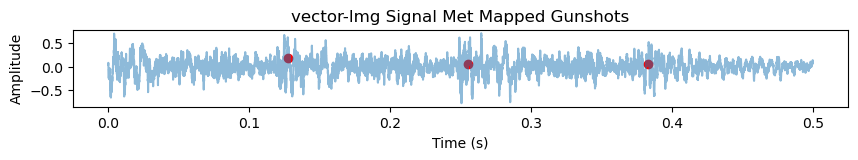

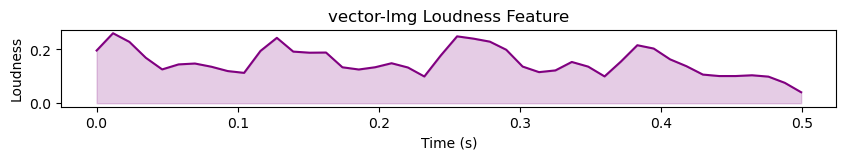

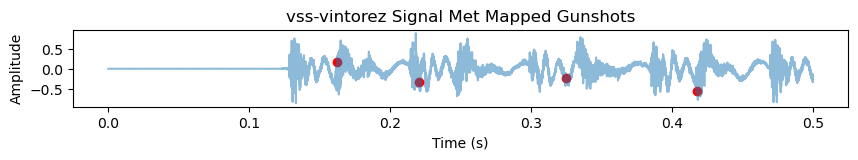

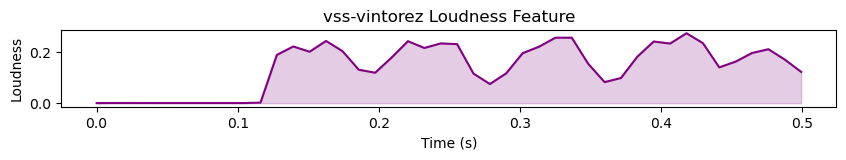

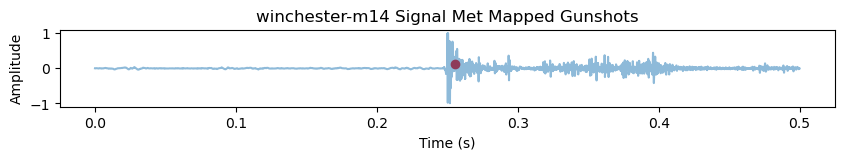

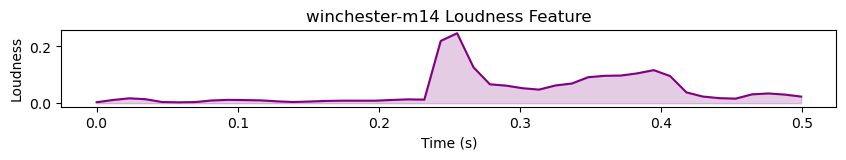

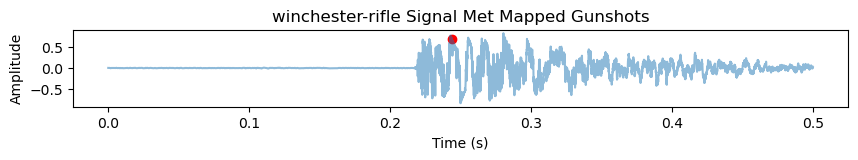

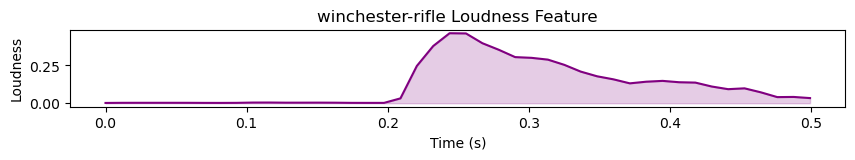

               firearm                                           filename  \
0  38sws-dot38-caliber  38sws-dot38-caliber_001_4a48b77c-72bf-4917-b8b...   
1  38sws-dot38-caliber  38sws-dot38-caliber_002_3ab0f1bb-f7fe-4cfe-a78...   
2  38sws-dot38-caliber  38sws-dot38-caliber_003_090f69a9-885c-45fb-a80...   
3  38sws-dot38-caliber  38sws-dot38-caliber_004_907b513b-dd5e-4756-a20...   
4  38sws-dot38-caliber  38sws-dot38-caliber_005_a7973dd2-b255-4711-9f9...   

                                                path  
0  data/audio/original_dataset\38sws-dot38-calibe...  
1  data/audio/original_dataset\38sws-dot38-calibe...  
2  data/audio/original_dataset\38sws-dot38-calibe...  
3  data/audio/original_dataset\38sws-dot38-calibe...  
4  data/audio/original_dataset\38sws-dot38-calibe...  


In [5]:
from audio_dataset import audio_eda
audio_df, counts, dur, srates, peak_freqs = audio_eda("data/audio/original_dataset")
print(audio_df.head())

## 2.2 Image EDA

Inladen van de metadata

In [6]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os

img_df = pd.read_csv("data/images/image_metadata.csv")
img_df.head()


,model,url,path
0,ak-12,https://upload.wikimedia.org/wikipedia/commons...,data/images\ak-12.jpg
1,ak-47,https://upload.wikimedia.org/wikipedia/commons...,data/images\ak-47.jpg
2,arctic-warfare-magnum,https://upload.wikimedia.org/wikipedia/commons...,data/images\arctic-warfare-magnum.jpg
3,beretta-92,https://upload.wikimedia.org/wikipedia/commons...,data/images\beretta-92.jpg
4,colt-1911,https://upload.wikimedia.org/wikipedia/commons...,data/images\colt-1911.jpg


Controleer of alle beelden goed zijn gedownload

In [7]:
img_df["exists"] = img_df["path"].apply(lambda p: os.path.exists(p))
img_df


,model,url,path,exists
0,ak-12,https://upload.wikimedia.org/wikipedia/commons...,data/images\ak-12.jpg,True
1,ak-47,https://upload.wikimedia.org/wikipedia/commons...,data/images\ak-47.jpg,True
2,arctic-warfare-magnum,https://upload.wikimedia.org/wikipedia/commons...,data/images\arctic-warfare-magnum.jpg,True
3,beretta-92,https://upload.wikimedia.org/wikipedia/commons...,data/images\beretta-92.jpg,True
4,colt-1911,https://upload.wikimedia.org/wikipedia/commons...,data/images\colt-1911.jpg,True
5,daewoo-k2,https://upload.wikimedia.org/wikipedia/commons...,data/images\daewoo-k2.jpg,True
6,desert-eagle,https://upload.wikimedia.org/wikipedia/commons...,data/images\desert-eagle.jpg,True
7,double-barrel-shotgun,https://upload.wikimedia.org/wikipedia/commons...,data/images\double-barrel-shotgun.jpg,True
8,dp-27-lmg,https://upload.wikimedia.org/wikipedia/commons...,data/images\dp-27-lmg.jpg,True
9,fn-p90,https://upload.wikimedia.org/wikipedia/commons...,data/images\fn-p90.jpg,True


Basis EDA: Afmetingen & bestandsgrootte

In [8]:
def get_img_stats(path):
    try:
        img = Image.open(path)
        width, height = img.size
        mode = img.mode
        file_size = os.path.getsize(path)
        return width, height, mode, file_size
    except:
        return None, None, None, None

img_df[["width", "height", "mode", "filesize"]] = img_df["path"].apply(
    lambda p: pd.Series(get_img_stats(p))
)

img_df


,model,url,path,exists,width,height,mode,filesize
0,ak-12,https://upload.wikimedia.org/wikipedia/commons...,data/images\ak-12.jpg,True,2543.0,1248.0,RGBA,1237086.0
1,ak-47,https://upload.wikimedia.org/wikipedia/commons...,data/images\ak-47.jpg,True,900.0,332.0,RGB,72464.0
2,arctic-warfare-magnum,https://upload.wikimedia.org/wikipedia/commons...,data/images\arctic-warfare-magnum.jpg,True,1998.0,810.0,RGB,305191.0
3,beretta-92,https://upload.wikimedia.org/wikipedia/commons...,data/images\beretta-92.jpg,True,2130.0,1377.0,RGB,356971.0
4,colt-1911,https://upload.wikimedia.org/wikipedia/commons...,data/images\colt-1911.jpg,True,2220.0,1488.0,L,1545577.0
5,daewoo-k2,https://upload.wikimedia.org/wikipedia/commons...,data/images\daewoo-k2.jpg,True,2000.0,654.0,RGB,197613.0
6,desert-eagle,https://upload.wikimedia.org/wikipedia/commons...,data/images\desert-eagle.jpg,True,1777.0,1185.0,RGB,682860.0
7,double-barrel-shotgun,https://upload.wikimedia.org/wikipedia/commons...,data/images\double-barrel-shotgun.jpg,True,4624.0,2136.0,RGB,2976899.0
8,dp-27-lmg,https://upload.wikimedia.org/wikipedia/commons...,data/images\dp-27-lmg.jpg,True,8448.0,5718.0,RGB,23841530.0
9,fn-p90,https://upload.wikimedia.org/wikipedia/commons...,data/images\fn-p90.jpg,True,3072.0,1728.0,RGB,477671.0


Visualiseer sample-afbeeldingen

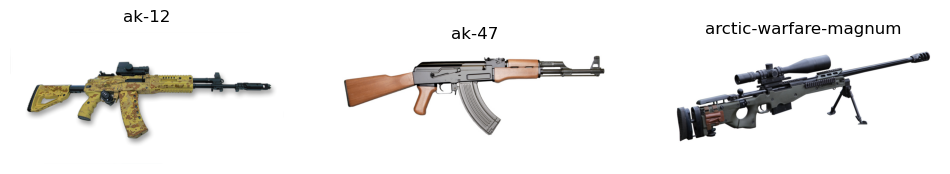

In [9]:
plt.figure(figsize=(12, 6))
for idx, row in img_df.head(3).iterrows():
    img = Image.open(row["path"])
    plt.subplot(1, 3, idx+1)
    plt.imshow(img)
    plt.title(row["model"])
    plt.axis("off")
plt.show()


Analyse van resoluties

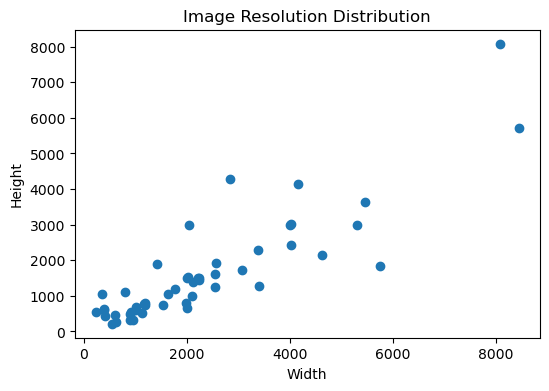

In [10]:
plt.figure(figsize=(6,4))
plt.scatter(img_df["width"], img_df["height"])
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Resolution Distribution")
plt.show()


## 2.3 Text EDA

In [10]:
# TESTING
import pandas as pd
import time

def scrape_firearm_descriptions(audio_df):
    base_url = "https://guns.fandom.com/wiki/"
    descriptions = []

    # iterate over UNIQUE firearm names
    for model in audio_df['firearm'].unique():
        search_term = model.replace(" ", "_").replace("-", "_")
        url = base_url + search_term

        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")

        paragraphs = soup.find_all("p")
        text = " ".join(p.get_text(strip=True) for p in paragraphs[:4])

        descriptions.append({
            "firearm": model,
            "url": url,
            "description": text
        })

        time.sleep(1)

    return pd.DataFrame(descriptions)

text_df = scrape_firearm_descriptions(audio_df)
display(text_df.head(50))

KeyError: 'firearm'

# 3 Preprocessing

## 3.1 Audio Preprocessing

De preprocessing richt zich op het omzetten van de ruwe audio naar bruikbare features voor de pipeline. Hiervoor wordt RMS-energie berekend om de volumevariaties van het geluid stabiel te meten. Daarna worden pieken in de energiecurve gedetecteerd met drempels voor hoogte, prominente pieken en minimale afstand tussen pieken. Dit zorgt ervoor dat echo’s of achtergrondgeluid niet worden meegeteld. Dit is namelijk wat wij tijdens EDA hebben al onderzocht. Per firearm worden de resultaten van alle 25 bestanden gemiddeld om twee features te verkrijgen: avg_shots_per_sec (het gemiddelde aantal schoten per seconde) en avg_loudness (gemiddelde piekamplitude).

In [63]:
from audio_dataset import extract_avg_features
firearm_features = extract_avg_features("data/audio/original_dataset/")
print(firearm_features.head(20))

                        firearm  avg_shots_per_sec  avg_loudness
0           38sws-dot38-caliber               3.52      0.221897
1                         ak-12               3.28      0.356807
2                         ak-47               5.12      0.404454
3         arctic-warfare-magnum               3.84      0.387424
4                    beretta-92               5.52      0.297721
5                     colt-1911               3.12      0.371421
6                     daewoo-k2               6.40      0.424999
7                  desert-eagle               4.96      0.374295
8         double-barrel-shotgun               4.24      0.364326
9                     dp-27-lmg               7.68      0.283701
10                       fn-p90               5.92      0.193190
11                      fn-scar               7.92      0.394437
12                        glock               4.24      0.193004
13                    glock-18c               4.88      0.350439
14    glock-19-9mm-luger-

## 3.2 Image Preprocessing

### Overzicht

Voor de afbeeldingsverwerking wordt een drie-staps pipeline gebruikt:

1. **Organisatie**: Afbeeldingen worden in mappenstructuur per wapen geplaatst
2. **Verwerking**: Achtergronden verwijderd en wapens gemeten (hoogte/breedte)
3. **Classificatie**: Onderscheid tussen één- en tweehandige wapens op basis van aspect ratio
4. **Analyse**: Visualisatie en export van resultaten

Het doel is om uit ruwe afbeeldingen gestructureerde features te extracten die bruikbaar zijn voor machine learning modellen.

### Stap 1: Organisatie van Afbeeldingen

**Waarom?**
- Afbeeldingen liggen momenteel los in `data/images/`
- De verwerkingsfunctie `process_weapon_images()` verwacht een structuur met submappen per wapen
- Dit maakt het mogelijk om meerdere afbeeldingen per wapen te verwerken

**Hoe?**
- Voor elke JPG/PNG-file wordt een submap gemaakt naar wapenaam
- Afbeeldingen worden gekopieerd naar `data/images/raw/[weapon_name]/`
- Dit zorgt voor schaalbare verwerking van grote datasets

**Output:**
- Georganiseerde mappenstructuur klaar voor batch-verwerking


In [68]:
# Stap 1: Voorbereiding - Organiseer afbeeldingen in mappen per wapen
import shutil

# De afbeeldingen liggen nu rechtstreeks in data/images/
# We moeten ze verplaatsen naar data/images/raw/[weapon_name]/

raw_dir = "data/images/raw"
os.makedirs(raw_dir, exist_ok=True)

# Zet alle JPG-bestanden in submappen
for img_file in os.listdir("data/images"):
    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        # Maak de wapenaam (verwijder extensie)
        weapon_name = os.path.splitext(img_file)[0]
        weapon_dir = os.path.join(raw_dir, weapon_name)
        os.makedirs(weapon_dir, exist_ok=True)
        
        # Verplaats afbeelding
        src = os.path.join("data/images", img_file)
        dst = os.path.join(weapon_dir, img_file)
        
        if os.path.exists(src) and not os.path.exists(dst):
            shutil.copy(src, dst)
            print(f"✓ Gekopieerd: {img_file} → {weapon_dir}/")

print("\n✓ Afbeeldingen zijn georganiseerd in submappen!")



✓ Afbeeldingen zijn georganiseerd in submappen!


### Stap 2: Achtergrondverwijdering & Wapenmeting

**Waarom?**
- Achtergronden leiden tot ruis in visuele features (kleur, textuur)
- Rembg-model verwijdert achtergrond met AI (U²-Net segmentatie)
- Na verwijdering kan het wapen exact worden gemeten in pixels

**Techniek:**
1. **Rembg (Background Removal):** Deep learning model voor semantische segmentatie
   - Input: Originele afbeelding
   - Output: PNG met alpha-kanaal (transparante achtergrond)

2. **Contourdetectie (OpenCV):** Vind de wapenvorm
   - Analyseert alpha-kanaal voor silhouet
   - Bepaalt bounding box van grootste contour
   - Berekent pixel-dimensies: breedte (w) en hoogte (h)

3. **Aspect Ratio:** w/h ratio bepaalt wapentype
   - Ratio > 2.0: Langwerpig → waarschijnlijk geweer met kolf → 2-handed
   - Ratio ≤ 2.0: Compacter → waarschijnlijk pistool → 1-handed

**Output:**
- `processed_image_path`: Pad naar PNG zonder achtergrond
- `pixel_width`, `pixel_height`: Gemeten afmetingen
- `aspect_ratio`: Hoogte/breedte verhouding
- `handling_type`: Classificatie (1-handed/2-handed)
- `stock_label_nl`: Nederlandse beschrijving


In [65]:
# Stap 2: Voer beeldverwerking uit (achtergrond verwijderen + meten)

# Verwerk alle wapens
processed_df = process_weapon_images(
    raw_base_dir="data/images/raw",
    processed_base_dir="data/images/processed"
)

# Opslaan naar CSV
processed_df.to_csv("data/images/weapon_analysis.csv", index=False)

print("\n" + "="*60)
print("RESULTATEN BEELDVERWERKING")
print("="*60)
print(f"✓ Total processed: {len(processed_df)} images")
print(f"✓ Saved to: data/images/weapon_analysis.csv")
print("\n" + processed_df.to_string())


Starten met beeldverwerking...


Wapens verwerken: 100%|██████████| 51/51 [01:15<00:00,  1.47s/it]

Klaar. 50 afbeeldingen succesvol verwerkt.

RESULTATEN BEELDVERWERKING
✓ Total processed: 50 images
✓ Saved to: data/images/weapon_analysis.csv

                                                             processed_image_path  pixel_width  pixel_height  aspect_ratio  has_stock_prediction handling_type                stock_label_nl                 weapon_key              original_filename
0                                           data/images/processed\ak-12\ak-12.png         2336           796          2.93                  True      2-handed  Waarschijnlijk kolf aanwezig                      ak-12                      ak-12.jpg
1                                           data/images/processed\ak-47\ak-47.png          863           265          3.26                  True      2-handed  Waarschijnlijk kolf aanwezig                      ak-47                      ak-47.jpg
2           data/images/processed\arctic-warfare-magnum\arctic-warfare-magnum.png         1868           664      

### Stap 3: Visualisatie & Analyse

**Waarom?**
- Exploratieve Data Analysis (EDA) onthult patronen en distributie
- Visuele validatie of de classificatie correct werkt
- Detecteert anomalieën en uitbijters

**Visualisaties:**

1. **Handling Type Distribution:** 
   - Bar chart telt hoe veel wapens als 1-handed vs 2-handed geclassificeerd zijn
   - Vertaalt abstract naar concrete aantallen

2. **Aspect Ratio Histogram:**
   - Toont verdeling van w/h verhoudingen
   - Rode lijn op 2.0 markeert classificatie-threshold
   - Links van lijn: pistolen (compacter), rechts: geweren (langer)

3. **Wapen Dimensies Scatter Plot:**
   - X-as: pixel-breedte, Y-as: pixel-hoogte
   - Kleur aangeduid door stock_prediction (rood=2-handed, blauw=1-handed)
   - Visualiseert fysieke afmetingen per wapen

4. **Verdeling Pie Chart:**
   - Procentuele verdeling van handling types
   - Toont balans in dataset

**Samenvatting per Wapen:**
- Gemiddelde afmetingen en aspect ratio per wapentype
- Razendsnel overzicht van alle verwerkte wapens


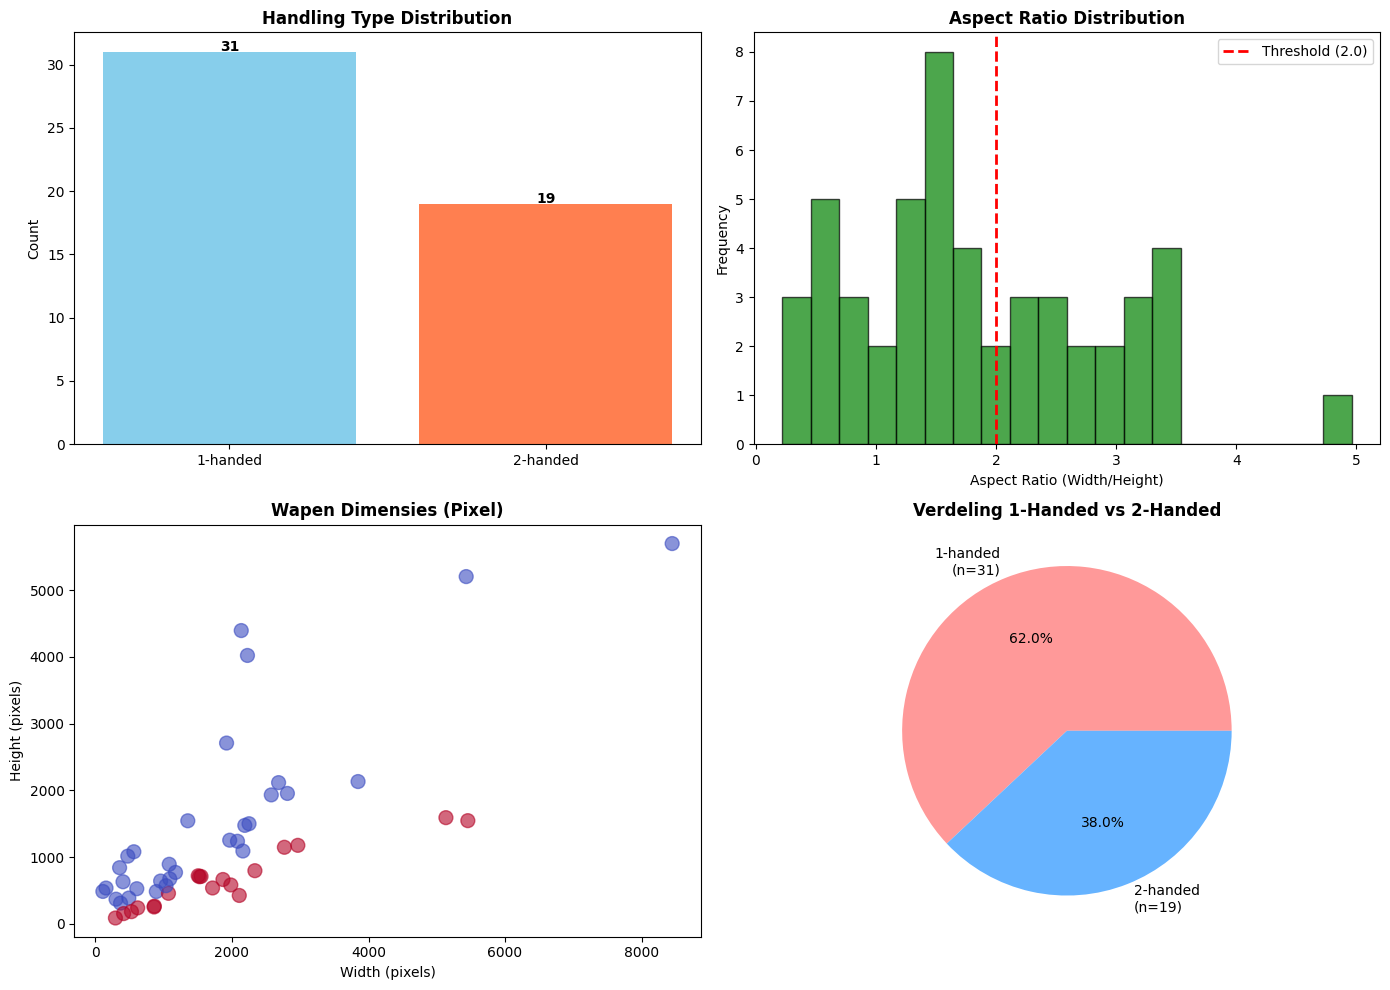


SAMENVATTING PER WAPEN
                           Avg Width  Avg Height  Avg Ratio  Handling                   Stock Label
weapon_key                                                                                         
ak-12                         2336.0       796.0       2.93  2-handed  Waarschijnlijk kolf aanwezig
ak-47                          863.0       265.0       3.26  2-handed  Waarschijnlijk kolf aanwezig
arctic-warfare-magnum         1868.0       664.0       2.81  2-handed  Waarschijnlijk kolf aanwezig
beretta-92                    1967.0      1253.0       1.57  1-handed      Waarschijnlijk geen kolf
colt-1911                     2188.0      1475.0       1.48  1-handed      Waarschijnlijk geen kolf
daewoo-k2                     1983.0       582.0       3.41  2-handed  Waarschijnlijk kolf aanwezig
desert-eagle                  1716.0       537.0       3.20  2-handed  Waarschijnlijk kolf aanwezig
double-barrel-shotgun         2136.0      4395.0       0.49  1-handed      W

In [66]:
# Stap 3: Visualisatie & Analyse

# Distributieverloop
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Handling type verdeling (1-handed vs 2-handed)
handling_counts = processed_df['handling_type'].value_counts()
axes[0, 0].bar(handling_counts.index, handling_counts.values, color=['skyblue', 'coral'])
axes[0, 0].set_title('Handling Type Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Count')
for i, v in enumerate(handling_counts.values):
    axes[0, 0].text(i, v + 0.1, str(v), ha='center', fontweight='bold')

# 2. Aspect Ratio distributie
axes[0, 1].hist(processed_df['aspect_ratio'], bins=20, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(2.0, color='red', linestyle='--', linewidth=2, label='Threshold (2.0)')
axes[0, 1].set_title('Aspect Ratio Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Aspect Ratio (Width/Height)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# 3. Pixel dimensions
axes[1, 0].scatter(processed_df['pixel_width'], processed_df['pixel_height'], 
                   c=processed_df['has_stock_prediction'], cmap='coolwarm', s=100, alpha=0.6)
axes[1, 0].set_title('Wapen Dimensies (Pixel)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Width (pixels)')
axes[1, 0].set_ylabel('Height (pixels)')

# 4. Aantal afbeeldingen per handling type
stock_dist = processed_df[['handling_type', 'has_stock_prediction']].groupby('handling_type').size()
axes[1, 1].pie(stock_dist.values, labels=[f"{x}\n(n={y})" for x, y in zip(stock_dist.index, stock_dist.values)],
               autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
axes[1, 1].set_title('Verdeling 1-Handed vs 2-Handed', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Samenvatting per wapen
print("\n" + "="*80)
print("SAMENVATTING PER WAPEN")
print("="*80)
summary = processed_df.groupby('weapon_key').agg({
    'pixel_width': 'mean',
    'pixel_height': 'mean',
    'aspect_ratio': 'mean',
    'handling_type': 'first',
    'stock_label_nl': 'first'
}).round(2)
summary.columns = ['Avg Width', 'Avg Height', 'Avg Ratio', 'Handling', 'Stock Label']
print(summary.to_string())


### Stap 4: Database Opslag (Load Phase) idk if to keep this or nah

**Waarom?**
- **Persistentie:** Data blijft behouden na sessie
- **Queryability:** SQL-queries op grote datasets efficiënter dan Pandas
- **Integratie:** Andere tools kunnen rechtstreeks uit database lezen
- **ETL-pipeline voltooid:** Extract → Transform → Load

**Hoe?**
- SQLite database (`weapons_data.db`) voor lokale opslag
- Tabel `image_features` met alle verwerkte imagedata
- Eenvoudig: `to_sql()` converteert DataFrame naar SQL-tabel

**Output:**
- Relatie-database met structured wapen-afbeelding features
- Kan later samengevoegd worden met audio- en tekstdata


In [67]:
import sqlite3

# Maak verbinding met je database
conn = sqlite3.connect("weapons_data.db")

# Sla de verwerkte image data op in de database
processed_df.to_sql('image_features', conn, if_exists='replace', index=False)

print("✅ Image data succesvol geladen in de SQL database!")

# Check of het erin staat
check_df = pd.read_sql_query("SELECT weapon_key, handling_type FROM image_features LIMIT 5", conn)
print(check_df)

conn.close()

✅ Image data succesvol geladen in de SQL database!
              weapon_key handling_type
0                  ak-12      2-handed
1                  ak-47      2-handed
2  arctic-warfare-magnum      2-handed
3             beretta-92      1-handed
4              colt-1911      1-handed


## 3.3 Text Preprocessing

In [7]:
print(audio_df.head(50))

                firearm                                           filename  \
0   38sws-dot38-caliber  38sws-dot38-caliber_001_4a48b77c-72bf-4917-b8b...   
1   38sws-dot38-caliber  38sws-dot38-caliber_002_3ab0f1bb-f7fe-4cfe-a78...   
2   38sws-dot38-caliber  38sws-dot38-caliber_003_090f69a9-885c-45fb-a80...   
3   38sws-dot38-caliber  38sws-dot38-caliber_004_907b513b-dd5e-4756-a20...   
4   38sws-dot38-caliber  38sws-dot38-caliber_005_a7973dd2-b255-4711-9f9...   
5   38sws-dot38-caliber  38sws-dot38-caliber_006_8f6c0053-4723-4bd0-a04...   
6   38sws-dot38-caliber  38sws-dot38-caliber_007_7bbf1085-7e14-44c0-9fe...   
7   38sws-dot38-caliber  38sws-dot38-caliber_008_47ec5352-1b86-477b-985...   
8   38sws-dot38-caliber  38sws-dot38-caliber_009_8ffbfbd4-7f3b-456b-8d2...   
9   38sws-dot38-caliber  38sws-dot38-caliber_010_30ac06ad-fdb6-496a-a8e...   
10  38sws-dot38-caliber  38sws-dot38-caliber_011_6320dc5c-a956-40b8-a66...   
11  38sws-dot38-caliber  38sws-dot38-caliber_012_907b513b-dd5e-4